# Descripción del proyecto

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B. (Sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios y las usuarias participan en experimentos.

## Descripción de los datos

Cada entrada de registro es una acción de usuario o un evento.

- *EventName:* nombre del evento.
- *DeviceIDHash:* identificador de usuario unívoco.
- *EventTimestamp:* hora del evento.
- *ExpId:* número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

In [39]:
#Importar librerias
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import ttest_ind

In [40]:
#Importar datos 
logs_exp= pd.read_csv('/datasets/logs_exp_us.csv',sep='\t')

In [41]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [42]:
logs_exp.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [43]:
logs_exp['DeviceIDHash'].duplicated().sum()

236575

## Preparar los datos para el análisis


### Cambia el nombre de las columnas de manera que sea conveniente para ti

In [44]:
#Se renombran las columnas
logs_exp.rename(columns={'DeviceIDHash': 'user_id', 'EventName':'event','EventTimestamp':'event_date','ExpId':'exp_id'}, inplace=True)
logs_exp.columns

Index(['event', 'user_id', 'event_date', 'exp_id'], dtype='object')

### Comprueba si hay tipos de datos y valores ausentes. Corrige los datos si es necesario

In [78]:
#logs_exp['event'].isna().sum()

### Agrega una columna de fecha y hora y una columna separada para las fechas

In [46]:
logs_exp['event_date']= pd.to_datetime(logs_exp["event_date"], unit='s')
logs_exp['event_date']

0        2019-07-25 04:43:36
1        2019-07-25 11:11:42
2        2019-07-25 11:28:47
3        2019-07-25 11:28:47
4        2019-07-25 11:48:42
                 ...        
244121   2019-08-07 21:12:25
244122   2019-08-07 21:13:59
244123   2019-08-07 21:14:43
244124   2019-08-07 21:14:58
244125   2019-08-07 21:15:17
Name: event_date, Length: 244126, dtype: datetime64[ns]

In [47]:
#Se crea la columna fecha para almacenar la fecha
logs_exp['date']= logs_exp["event_date"].values.astype(dtype='datetime64[D]')
#Se crea la columna hora para almacenar las horas
logs_exp['hour']=logs_exp['event_date'].apply(lambda x: x.time())

In [48]:
logs_exp.head(2)

,event,user_id,event_date,exp_id,date,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42


### Estudiar y comprobar los datos

#### ¿Cuántos eventos hay en los registros?

In [49]:
print(f"""
Número de eventos totales: {len(logs_exp)}

Eventos por tipo de evento: {logs_exp.groupby("event")["user_id"].count()}
""")


Número de eventos totales: 244126

Eventos por tipo de evento: event
CartScreenAppear            42731
MainScreenAppear           119205
OffersScreenAppear          46825
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: user_id, dtype: int64



#### ¿Cuántos usuarios y usuarias hay en los registros?

In [50]:
print(f"""
Usuarios únicos: {logs_exp["user_id"].nunique()}
""")


Usuarios únicos: 7551



#### ¿Cuál es el promedio de eventos por usuario?

In [51]:
print(f"""
Promedio de eventos por usuario: {round(len(logs_exp) / logs_exp["user_id"].nunique(), 4)}
""")



Promedio de eventos por usuario: 32.3303



#### ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?


Fecha mínima: 2019-07-25 00:00:00
Fecha máxima: 2019-08-07 00:00:00



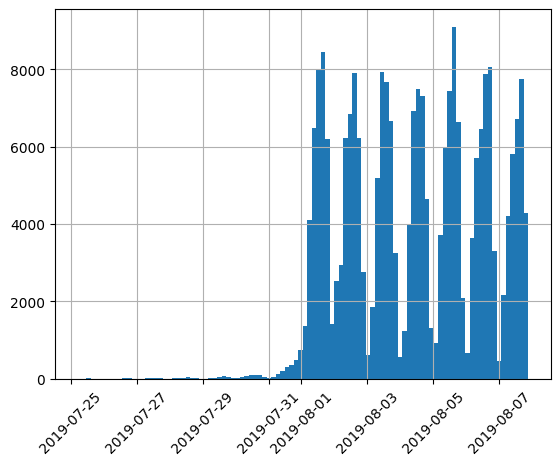

<Figure size 640x480 with 0 Axes>

In [52]:
print(f"""
Fecha mínima: {logs_exp["date"].min()}
Fecha máxima: {logs_exp["date"].max()}
""")

logs_exp["event_date"].hist(bins=100)
plt.xticks(rotation=45)  # Rotación de 45 grados
plt.show()
plt.clf()

Como podemos observar en el gráfico contamos con pocos datos antes del 31 de julio del 2019, por lo que podríamos excluirlos ya que para nuestro experimiento debemos intentar tener las mismas condiciones en las tres pruebas.

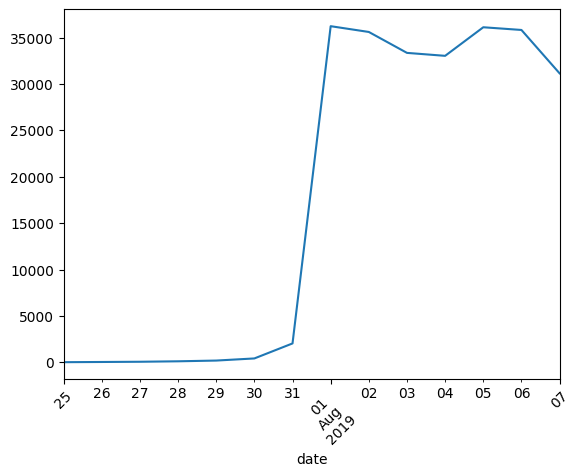

<Figure size 640x480 with 0 Axes>

In [53]:
# %%
logs_exp.groupby("date")["user_id"].count().plot()
plt.xticks(rotation=45)  # Rotación de 45 grados
plt.show()
plt.clf()

Se traza un gráfico de líneas para que sea aún más fácil identificar donde tenemos un cambio en el comportamiento de los datos.
Obteniendo que el 1ero de Agosto es el día en el que comenzo un aumento de los datos y tomamos esa fecha como referencia para filtrar nuestros datos.

In [54]:
#Se crea filtro para las fechas posteriores al 31 de julio del 2019
logs_exp_filtered = logs_exp.loc[logs_exp["date"]>'31-07-2019']

2019-07-25 00:00:00
2019-08-07 00:00:00


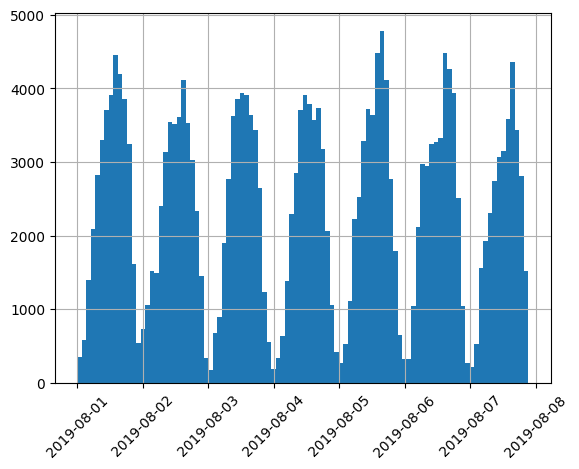

In [55]:
#Se crea grafico para observar los valores filtrados.
logs_exp_filtered = logs_exp[logs_exp['date']>pd.to_datetime('2019-07-31')]
print(logs_exp['date'].min())
print(logs_exp['date'].max())
logs_exp_filtered["event_date"].hist(bins=100)
plt.xticks(rotation=45)  # Rotación de 45 grados
plt.show()

#### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [56]:
#Se corrobora el número de datos perdidos tras el filtrado. 
print(f"""
Porcentaje de usuarios que permanecen: {100*round(logs_exp_filtered["user_id"].nunique() / logs_exp["user_id"].nunique(), 3)}
Porcentaje de usuarios que eliminamos: {100*round(1 - logs_exp_filtered["user_id"].nunique() / logs_exp["user_id"].nunique(), 3)}
""")


Porcentaje de usuarios que permanecen: 99.8
Porcentaje de usuarios que eliminamos: 0.2



Al calcular proporción de los datos excluidos obtenemos que solo es el 0.2% de los datos totales, este valor se encuentra por debajo del 2%, así que no tenemos problemas por excluir los datos viejos.

#### Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

In [57]:
#Se calcula la proporcion de usuarios en los 3 grupos
logs_exp_filtered.groupby("exp_id")["user_id"].count()/len(logs_exp_filtered)

exp_id
246    0.329157
247    0.319717
248    0.351126
Name: user_id, dtype: float64

Como podemos observar tenemos aproximadamente la misma proporción de datos en los tres grupos experimentales, lo cual ayuda a que nuestro experimento sea maás real y tenga menos sesgo.

### Estudiar el embudo de eventos

#### Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [58]:
#Se agrupa por evento y se reordena de forma descendente
logs_exp_filtered.groupby('event')['user_id'].count().reset_index().sort_values('user_id',ascending=False)

,event,user_id
1,MainScreenAppear,117431
2,OffersScreenAppear,46350
0,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


#### Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

In [59]:
logs_exp_filtered.groupby("event")["user_id"].nunique().sort_values(ascending=False)

event
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

In [60]:
logs_exp_filtered.groupby("event")["user_id"].nunique() / logs_exp_filtered["user_id"].nunique()

event
CartScreenAppear           0.495620
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: user_id, dtype: float64

#### ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

In [61]:
logs_exp_filtered['event'].value_counts()

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event, dtype: int64

1) MainScreenAppear 
2) Tutorial 
3) OffersScreenAppear 
4) CartScreenAppear 
5) PaymentScreenSuccessful
Este es el probable orden en el que ocurrieron las acciones, sin embargo, debemos tomar en cuenta que muchas veces los tutoriales se pueden saltar por lo que puede ser la razon por la que tenemos tan baja tasa de conversión en esa etapa.

#### Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).

In [62]:
#Creamos un embudo agrupando por evento y extrayendo los valores unicos de user_id.
users_by_event = logs_exp_filtered.groupby("event")["user_id"].nunique(
).sort_values(ascending=False).reset_index()

#Se agrega la columna user_in_previous_step para extraer los usuarios de la anterior etapa
users_by_event["users_in_previous_step"] = users_by_event["user_id"].shift(1)

#Se calcula la conversión dividiendo el número de usuarios de la etapa entre el número de usuarios de la etapa previa. 
users_by_event["conversion_previous_step"] = users_by_event["user_id"] / \
    users_by_event["users_in_previous_step"]

#Se calcula el porcentaje de usuarios perdidos en la nueva etapa.
users_by_event["dropoff_rate"] = 1 - users_by_event["conversion_previous_step"]

In [63]:
users_by_event

,event,user_id,users_in_previous_step,conversion_previous_step,dropoff_rate
0,MainScreenAppear,7419,NaN,NaN,NaN
1,OffersScreenAppear,4593,7419.0,0.619086,0.380914
2,CartScreenAppear,3734,4593.0,0.812976,0.187024
3,PaymentScreenSuccessful,3539,3734.0,0.947777,0.052223
4,Tutorial,840,3539.0,0.237355,0.762645


#### ¿En qué etapa pierdes más usuarios y usuarias?

Se pierden muchos usuarios de la etapa del tutorial, tiene la conversión más baja, y la perdida de usuarios más alta. Sin embargo, esto se puede deber a que la etapa tiene una opción para saltar la etapa. Por otro lado, la segunda con mayor perdida son las ofertas con un 38% de usuarios que abandonan la p]agina antes de revisar las ofertas. Habria que puede causar este suceso, pero no contamos con información suficiente para realizarlo.

#### ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [64]:
logs_exp_filtered.head()

,event,user_id,event_date,exp_id,date,hour
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59


In [65]:
# Se define una secuencia para los eventos para revisar quienes pasaron por todas las fases.
event_sequence = ['MainScreenAppear','Tutorial','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']

# Se filtran los usuarios que han pasado por todos los eventos.
users_by_event = {event: set(logs_exp_filtered[logs_exp_filtered['event'] == event]['user_id']) for event in event_sequence}

# Se crea una intersección para establecer que usarios completaron el proceso.
users_completed_journey = set.intersection(*users_by_event.values())

# Se calcula el porcentaje, dividiendo los usuarios que completaron el proceso entre el número total de usuarios.
total_users = logs_exp_filtered['user_id'].nunique()
percentage_completed = len(users_completed_journey) / total_users * 100

print(f"El {percentage_completed:.2f}% de usuarios completaron todo el viaje desde su primer evento hasta el pago.")

El 6.19% de usuarios completaron todo el viaje desde su primer evento hasta el pago.


Es un porcentaje bajo, sin embargo, esto se debe a que la conversion en esta etapa es baja, por lo cual es baja la cantidad de usuarios que atraviesan por todos los eventos.

### Estudiar los resultados del experimento

#### ¿Cuántos usuarios y usuarias hay en cada grupo?

In [66]:
logs_exp_filtered.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

#### Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [67]:
conversions = logs_exp_filtered[["user_id", "exp_id"]].drop_duplicates()

converted = pd.DataFrame(data={
    "user_id": logs_exp_filtered[logs_exp_filtered["event"] == "OffersScreenAppear"]["user_id"].unique(),
    "converted": 1
})

conversions = conversions.merge(converted, on="user_id", how="left")
conversions["converted"] = conversions["converted"].fillna(0)

conversions.head(10)

,user_id,exp_id,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0
5,205293431553451771,246,1.0
6,6121366368901703338,248,1.0
7,6022375714473447159,248,1.0
8,2712290788139738557,247,1.0
9,6049698452889664846,247,1.0


In [68]:
logs_exp_filtered["group"] = np.where(
    (logs_exp_filtered["exp_id"] == 246) | (
        logs_exp_filtered["exp_id"] == 247),
    ["control"] * len(logs_exp_filtered),
    ["experiment"] * len(logs_exp_filtered)
)

/tmp/ipykernel_100/1237287414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_exp_filtered["group"] = np.where(


In [69]:
logs_exp_filtered.head()

,event,user_id,event_date,exp_id,date,hour,group
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28,control
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00,control
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55,control
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58,control
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59,control


In [70]:
conversions.head()

,user_id,exp_id,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0


In [71]:
statistic, pvalue = ttest_ind(
    conversions[conversions["exp_id"] == 246]["converted"],
    conversions[conversions["exp_id"] == 247]["converted"]
)
alpha = 0.002

print(f"""
Statistic: {statistic}
p-value: {pvalue}
""")

if (pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


Statistic: 1.154910721737677
p-value: 0.24818223444867904

No podemos rechazar la hipótesis nula


#### Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. 

In [72]:
conversions.groupby("exp_id")["converted"].mean()

exp_id
246    0.620773
247    0.604855
248    0.603469
Name: converted, dtype: float64

#### Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [73]:
def t_test(df, group1, group2, event, group_col="exp_id"):

    conversions = df[["user_id", group_col]].drop_duplicates()

    converted = pd.DataFrame(data={
        "user_id": df[df["event"] == event]["user_id"].unique(),
        "converted": 1
    })

    conversions = conversions.merge(converted, on="user_id", how="left")
    conversions["converted"] = conversions["converted"].fillna(0)

    statistic, pvalue = ttest_ind(
        conversions[conversions[group_col] == group1]["converted"],
        conversions[conversions[group_col] == group2]["converted"]
    )

    return statistic, pvalue

In [74]:
events = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful','Tutorial']

print("Running A/A tests...")
for event in events:
    _, pvalue = t_test(logs_exp_filtered, 246, 247, event)

    print(f"""
  Event: {event}
  p-value: {pvalue}
  """)
    print()

Running A/A tests...

  Event: MainScreenAppear
  p-value: 0.7571174621103072
  


  Event: OffersScreenAppear
  p-value: 0.24818223444867904
  


  Event: CartScreenAppear
  p-value: 0.22891646330485427
  


  Event: PaymentScreenSuccessful
  p-value: 0.11461233163248476
  


  Event: Tutorial
  p-value: 0.9377151544645461
  



En ninguno de los casos nuestro p-value fue menor que nuestro valor alfa por lo que no podemos rechazar la hipotesis nula. 

#### Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [75]:
events = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful','Tutorial']
controls = [246, 247]

print("Running A/B tests...")
print()
for event in events:

    print(f"Event: {event}")

    for control in controls:

        _, pvalue = t_test(logs_exp_filtered, control, 248, event)

        print(f"""
    Comparison: {control} vs. experiment
    p-value: {pvalue}
    """)

    _, pvalue = t_test(logs_exp_filtered, "control",
                       "experiment", event, group_col="group")

    print(f"""
  Comparison: all control vs. experiment
  p-value: {pvalue}
  """)

Running A/B tests...

Event: MainScreenAppear

    Comparison: 246 vs. experiment
    p-value: 0.29506606465679136
    

    Comparison: 247 vs. experiment
    p-value: 0.45880437959723175
    

  Comparison: all control vs. experiment
  p-value: 0.29430776026592703
  
Event: OffersScreenAppear

    Comparison: 246 vs. experiment
    p-value: 0.20843948636199391
    

    Comparison: 247 vs. experiment
    p-value: 0.9198015341631126
    

  Comparison: all control vs. experiment
  p-value: 0.4343224300849128
  
Event: CartScreenAppear

    Comparison: 246 vs. experiment
    p-value: 0.07845751752267907
    

    Comparison: 247 vs. experiment
    p-value: 0.5787080147829398
    

  Comparison: all control vs. experiment
  p-value: 0.18180539347221455
  
Event: PaymentScreenSuccessful

    Comparison: 246 vs. experiment
    p-value: 0.2123337471133262
    

    Comparison: 247 vs. experiment
    p-value: 0.7374027184332623
    

  Comparison: all control vs. experiment
  p-value: 0.600

En este caso, ninguno de los dos grupos presento un pvalue menor que nuestro valor alfa, sin embargo, el primer grupo de control tuvo un valor cercano, mientras que el segundo grupo el valor de pvalue fue mucho mayor, por lo que podemos concluir que el segundo grupo de control es mucho mejor referencia para comparar con el grupo experimental. 

#### ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

In [76]:
n_pruebas = 15
significancia = 0.01

print(f"""
Nivel de significancia real: {1-(1 - significancia)**n_pruebas}
""")

significancia = 0.002

print(f"""
Nivel de significancia real: {1-(1 - significancia)**n_pruebas}
""")


Nivel de significancia real: 0.13994164535871156


Nivel de significancia real: 0.02958361825577649



Obtuvimos que un 13% de probabilidad de cometer un error de tipo I con un 1% de significacia. lo cual es muy grave ya que contamos con 15 pruebas y esto quiere decir que contamos con almenos un falso positivo en nuestro análisis.

Por otro lado, cambiar el nivel de significación a 0.002 controla mejor el error acumulado. reduciendo el numero de falsos posivos y más cercano a los valores que se consideran aceptables. 